
image 1/1 /data/corob/experiments/plates-segment/notebooks/images/sequence/07.jpg: 1280x960 4 Plate 2s, 1 Plate 4, 68.4ms
Speed: 7.9ms preprocess, 68.4ms inference, 85.2ms postprocess per image at shape (1, 3, 1280, 960)


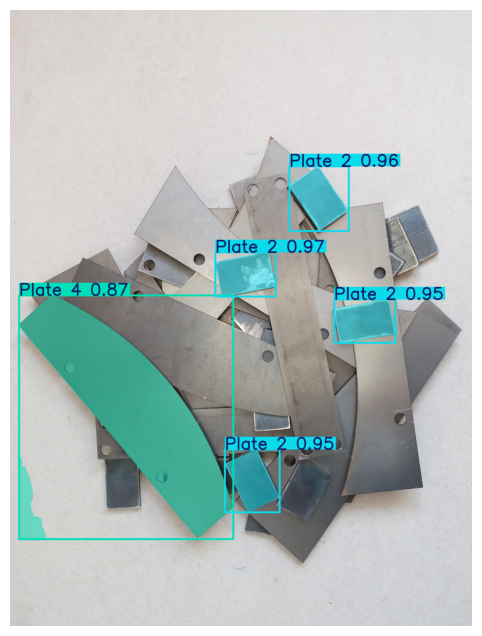

In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
import math

model = YOLO("../runs/segment/train11/weights/best.pt")
# train11 is trained with yolo train data=./dataset/data.yaml batch=0.8 model=yolo11n-seg.pt imgsz=1280 device=0 epochs=1000 patience=250

image = "./images/sequence/07.jpg"
result = model(image, conf=0.7)[0]

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(result.plot(), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [2]:
# Класове на обектите
classes = result.boxes.cls.cpu().numpy()  # Класове като индекси (floats)
# Вероятности (confidence)
confidences = result.boxes.conf.cpu().numpy()
# Маски (bool маски с размер на изображението)
masks = result.masks.data.cpu().numpy()  # shape: [num_instances, H, W]

In [3]:
print(classes)

[          1           1           1           1           3]


In [4]:
print(confidences)

[    0.96893     0.96498     0.95374     0.95101     0.87386]


In [5]:
print(model.names)

{0: 'Plate 1', 1: 'Plate 2', 2: 'Plate 3', 3: 'Plate 4', 4: 'Plate 5'}


In [6]:
print(masks[0].shape)

(1280, 960)


In [7]:
print(result.orig_img.shape)

(5632, 4224, 3)


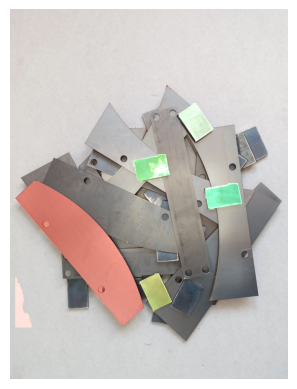

In [8]:
img = cv2.imread(image)
img = cv2.resize(img, (masks.shape[2], masks.shape[1]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for i, mask in enumerate(masks):
    color = np.random.randint(0, 255, size=3, dtype=np.uint8)
    colored_mask = np.zeros_like(img)
    for c in range(3):
        colored_mask[:, :, c] = mask * color[c]

    img = cv2.addWeighted(img, 1.0, colored_mask, 0.5, 0)

plt.imshow(img)
plt.axis("off")
plt.show()

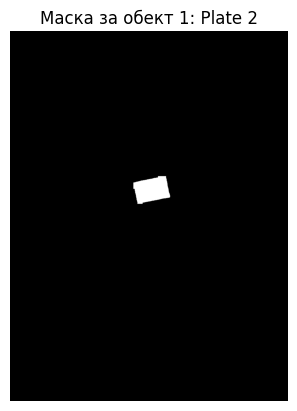

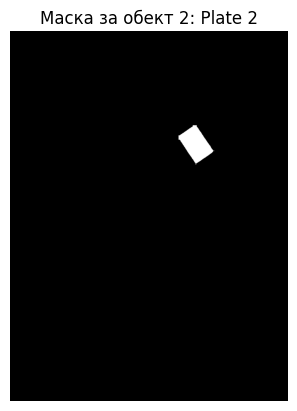

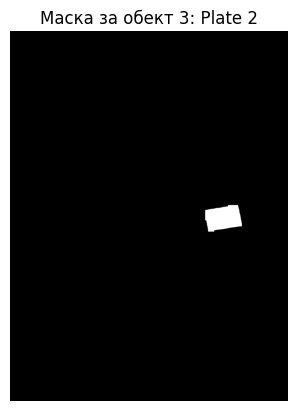

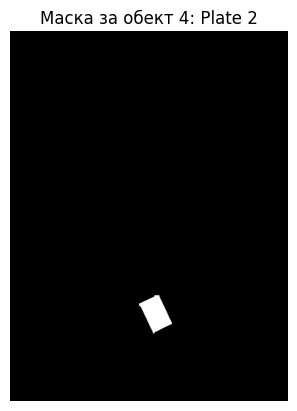

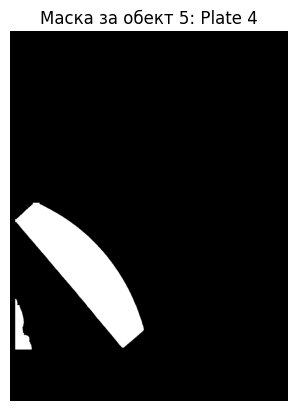

In [9]:
# Показваме всяка маска самостоятелно
for i, mask in enumerate(masks):
    plt.figure()
    plt.imshow(mask.astype(np.uint8), cmap='gray')  # 'gray' прави ясен черно-бял изглед
    plt.title(f"Маска за обект {i+1}: {model.names[int(classes[i])]}")
    plt.axis("off")
    plt.show()

In [10]:
def get_precise_box(mask):
    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print("Object not found")
        return None, None

    main_contour = max(contours, key=cv2.contourArea)

    M = cv2.moments(main_contour)
    if M["m00"] != 0:
        center_x = int(M["m10"] / M["m00"])
        center_y = int(M["m01"] / M["m00"])
    else:
        center_x, center_y = 0, 0

    rect = cv2.minAreaRect(main_contour)
    box = cv2.boxPoints(rect)
    box = np.int32(box)
    angle = rect[2]

    width, height = rect[1]
    if width < height:
        angle = 90 + angle
    angle = 90 - angle

    return main_contour, (center_x, center_y, angle, max(width, height), min(width, height))

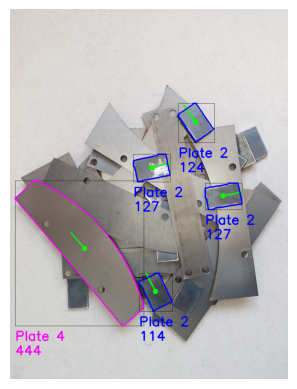

[{'name': 'Plate 2', 'confidence': np.float32(0.9689302), 'area': 8637, 'x': -1.0133333333333334, 'y': -0.042499999999999996, 'z': 0.1, 'theta': -1.346380397007462}, {'name': 'Plate 2', 'confidence': np.float32(0.9649838), 'area': 8377, 'x': 0.0, 'y': 0.05625, 'z': 0.1, 'theta': 0.6061353309439801}, {'name': 'Plate 2', 'confidence': np.float32(0.95374036), 'area': 8799, 'x': 0.6333333333333333, 'y': -0.10375, 'z': 0.1, 'theta': -1.3815973734723972}, {'name': 'Plate 2', 'confidence': np.float32(0.95101094), 'area': 8122, 'x': -0.92, 'y': -0.310625, 'z': 0.1, 'theta': 0.4636475573511981}, {'name': 'Plate 4', 'confidence': np.float32(0.8738624), 'area': 81282, 'x': -2.5533333333333337, 'y': -0.21749999999999997, 'z': 0.1, 'theta': 0.7023629311376497}]


In [11]:
img = cv2.imread(image)
img = cv2.resize(img, (masks.shape[2], masks.shape[1]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

detected_objects = []
best_objects = {}

# colors = np.random.randint(0, 255, size=(5,3), dtype=np.uint8)

colors = [(255, 0, 0),
          (0, 0, 255),
          (0, 255, 255),
          (255, 0, 255),
          (255, 255, 0),
          (255, 255, 255),
          (0, 0, 0)]

for i, mask in enumerate(masks):
    # color = tuple(int(c) for c in colors[int(classes[i])])
    color = colors[int(classes[i])]
    precise_box, (x, y, theta, w, h) = get_precise_box(mask.astype(np.uint8))

    x1, y1, w, h = cv2.boundingRect(precise_box)

    cv2.rectangle(img, (x1, y1), (x1 + w, y1 + h), (0, 0, 0), 1)
    
    cv2.circle(img, (x, y), 9, (0, 255, 0), -1)
    start = (x, y)
    end = (int(start[0] - math.sin(math.radians(theta)) * 70),
           int(start[1] - math.cos(math.radians(theta)) * 70))
    cv2.line(img, start, end, (0, 255, 0), 3)

    cv2.drawContours(img, [precise_box], -1, tuple(int(c) for c in color), 3)

    try:
        predicted_class_name = f"{model.names[int(classes[i])]}"
    except:
        predicted_class_name = "Unknown"
    
    cv2.putText(img, predicted_class_name, (x1, y1 + h + 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 3)

    area = int(cv2.contourArea(precise_box))

    cv2.putText(img, f"{w}", (x1, y1 + h + 100),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 3)
    
    # For the simulation in vision_pick_and_place.wbt:
    #   x -> [0; 1280] =  [-0.4; 0.4]
    #   y -> [0; 960] = -[-0.3; 0.3]
    detected_object = {
        "name": model.names[int(classes[i])],
        "confidence": confidences[i],
        "area": area,
        "x": 0.8 * (x - (1280 + 0) / 2) / (120 - 0),
        "y": - 0.6 * (y - (960 + 0) / 2) / (960 - 0),
        "z": 0.1,
        "theta": math.radians(theta)
    }

    detected_objects.append(detected_object)
    if detected_object["name"] not in best_objects or \
            best_objects[detected_object["name"]]["confidence"] < detected_object["confidence"]:
        best_objects[detected_object["name"]] = detected_object

plt.imshow(img)
plt.axis("off")
plt.show()

print(detected_objects)